In [7]:
from datetime import datetime
from elasticsearch import Elasticsearch
import os 
import glob
import pprint
import regex
import matplotlib.pyplot as plt

In [8]:
import spacy
from collections import Counter, OrderedDict
import numpy as np
import random

In [9]:
es = Elasticsearch('http://localhost:9200')
es.info()

{'name': 'DESKTOP-V2HVSQ4',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'j0wajJxETBCrSGJPdFO_4g',
 'version': {'number': '7.10.1',
  'build_flavor': 'default',
  'build_type': 'zip',
  'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa',
  'build_date': '2020-12-05T01:00:33.671820Z',
  'build_snapshot': False,
  'lucene_version': '8.7.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [5]:
es.indices.analyze(
    {
        "text": 'klauzulą   "< < tajne > >"  ze względu na obronność i bezpieczeństwo państwa oraz <body>tagi</body>',
        "tokenizer": "keyword",
        "char_filter": [
            "html_strip"
        ],
    },
)

C:\Users\oookk\AppData\Local\Temp/ipykernel_8484/3103961476.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.analyze(


{'tokens': [{'token': 'klauzulą   "< \n >"  ze względu na obronność i bezpieczeństwo państwa oraz \ntagi\n',
   'start_offset': 0,
   'end_offset': 99,
   'type': 'word',
   'position': 0}]}

1. Make sure the texts in the corpus does not contain HTML code.

In [44]:
# Index with analyzer
es.indices.create(
    index='my_index102',
    body={
        "settings": {
            "index": {
                "analysis": {
                    "filter": {
                        "kodeks_synonym_filter": {
                            "type": "synonym",
                            "synonyms": [
                                "kpk => kodeks postępowania karnego",
                                "kpc => kodeks postępowania cywilnego",
                                "kk => kodeks karny",
                                "kc => kodeks cywilny",
                            ]
                        }
                    },
                    "analyzer": {
                        "default": {
                            "type": "custom",
                            "tokenizer": "standard",
                            "filter": ["kodeks_synonym_filter", "morfologik_stem", "lowercase"],
                            "char_filter": [ # added html_strip filter
                                "my_custom_html_strip_char_filter"
                            ]
                        }
                    },
                    "char_filter": {
                        "my_custom_html_strip_char_filter": {
                        "type": "html_strip",
                        "escaped_tags": [
                            "tajne"
                        ]
                        }
                    }
                }
            }
        },
        "mappings": {
            "properties": {
                "act": {
                    "type": "text",
                    "term_vector": "with_positions_offsets"
                }
            }
        }
    })

C:\Users\oookk\AppData\Local\Temp/ipykernel_5824/359446903.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(


RequestError: RequestError(400, 'resource_already_exists_exception', 'index [my_index101/2jP5s8V7R2WOQsjiysaZsw] already exists')

In [4]:
es.indices.create(index='test-index2')

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'test-index2'}

In [51]:
es.indices.analyze(
    {
        "text": 'klauzulą   "< < tajne > >"  ze względu na obronność i bezpieczeństwo państwa oraz <body>tagi</body><b>asd</b>',
    },
    # "my_index101"
    "test-index1"
)

C:\Users\oookk\AppData\Local\Temp/ipykernel_8484/2907145203.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.analyze(


{'tokens': [{'token': 'klauzulą',
   'start_offset': 0,
   'end_offset': 8,
   'type': '<ALPHANUM>',
   'position': 0},
  {'token': 'tajne',
   'start_offset': 16,
   'end_offset': 21,
   'type': '<ALPHANUM>',
   'position': 1},
  {'token': 'ze',
   'start_offset': 28,
   'end_offset': 30,
   'type': '<ALPHANUM>',
   'position': 2},
  {'token': 'względu',
   'start_offset': 31,
   'end_offset': 38,
   'type': '<ALPHANUM>',
   'position': 3},
  {'token': 'na',
   'start_offset': 39,
   'end_offset': 41,
   'type': '<ALPHANUM>',
   'position': 4},
  {'token': 'obronność',
   'start_offset': 42,
   'end_offset': 51,
   'type': '<ALPHANUM>',
   'position': 5},
  {'token': 'i',
   'start_offset': 52,
   'end_offset': 53,
   'type': '<ALPHANUM>',
   'position': 6},
  {'token': 'bezpieczeństwo',
   'start_offset': 54,
   'end_offset': 68,
   'type': '<ALPHANUM>',
   'position': 7},
  {'token': 'państwa',
   'start_offset': 69,
   'end_offset': 76,
   'type': '<ALPHANUM>',
   'position': 8},
 

In [10]:
tajne = es.search(
    index="my_index13",
    body={
        "query": {
            "match": {
                "text": {
                    "query": "&#60; tajne",
                }
            }
        },
        "highlight": {
            "fields": {
                "text": {}
            },
        }
    },
    size="10"
)["hits"]["hits"]
best_scores = [d['_score'] for d in tajne]
best_ids = [d['_id'] for d in tajne]
best_ids, best_scores

C:\Users\oookk\AppData\Local\Temp/ipykernel_6276/2570607959.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  tajne = es.search(


(['1995_692.txt',
  '1999_95.txt',
  '2001_247.txt',
  '1997_501.txt',
  '1997_500.txt',
  '1998_576.txt',
  '1994_195.txt',
  '1995_436.txt',
  '1993_602.txt',
  '1995_681.txt'],
 [6.84731,
  6.7660007,
  6.725336,
  6.5522695,
  6.2916374,
  6.012521,
  6.0110908,
  5.9613905,
  5.952883,
  5.5183425])

In [11]:
files = [f for f in glob.glob('../ustawy/*')]
len(files)

1179

In [12]:
files_content = []
for file in glob.glob('../ustawy/*'):
    fname = os.path.basename(file)
    with open(file, encoding='UTF-8') as f:
        text = f.read()
        files_content.append(text)

In [13]:
regexp_html = r'<[a-z]*>'

for file in files:
    with open(file, encoding='UTF-8') as f:
        text = f.read()
        reg_html = regex.findall(regexp_html, text, flags=regex.IGNORECASE) 
        if reg_html:
            print(reg_html)
            

In [14]:
from spacy.tokenizer import Tokenizer
from spacy.lang.pl import Polish
nlp = Polish()
tokenizer = Tokenizer(nlp.vocab)

test

In [15]:
tokenizer

In [16]:
tokens = tokenizer("This is a sentence")
print(len(tokens) == 4)
print(tokens)

True
This is a sentence


In [17]:
files[0]

'../ustawy\\1993_599.txt'

In [18]:
import spacy
spacy.__version__

'3.1.4'

In [19]:
texts = files_content
texts = ["ala ma kota", "ustawa ustawie nie jest równa nigdy, ale ustawa ustawę zje"]
tokenized = []
for doc in tokenizer.pipe(texts, batch_size=1):
    # t = tokenizer(doc)
    # print(doc.vocab)
    # print(doc.)
    tokenized.append(doc)
    pass
tokenized

[ala ma kota, ustawa ustawie nie jest równa nigdy, ale ustawa ustawę zje]

In [20]:
texts = files_content
tokenized = []
for i, t in enumerate(texts):
    # print(files[i])
    tokens = tokenizer(t)
    # print(len(tokens))
    # pass
tokenized

[]

In [21]:
tokenizer.explain(files_content[0])

[('TOKEN', 'Dz.U.'),
 ('TOKEN', 'z'),
 ('TOKEN', '1993'),
 ('TOKEN', 'r.'),
 ('TOKEN', 'Nr'),
 ('TOKEN', '129,'),
 ('TOKEN', 'poz.'),
 ('TOKEN', '599'),
 ('TOKEN', 'USTAWA'),
 ('TOKEN', 'z'),
 ('TOKEN', 'dnia'),
 ('TOKEN', '9'),
 ('TOKEN', 'grudnia'),
 ('TOKEN', '1993'),
 ('TOKEN', 'r.'),
 ('TOKEN', 'o'),
 ('TOKEN', 'zmianie'),
 ('TOKEN', 'ustawy'),
 ('TOKEN', 'o'),
 ('TOKEN', 'podatku'),
 ('TOKEN', 'od'),
 ('TOKEN', 'towarów'),
 ('TOKEN', 'i'),
 ('TOKEN', 'usług'),
 ('TOKEN', 'oraz'),
 ('TOKEN', 'o'),
 ('TOKEN', 'podatku'),
 ('TOKEN', 'akcyzowym'),
 ('TOKEN', 'Art.'),
 ('TOKEN', '1.'),
 ('TOKEN', 'W'),
 ('TOKEN', 'ustawie'),
 ('TOKEN', 'z'),
 ('TOKEN', 'dnia'),
 ('TOKEN', '8'),
 ('TOKEN', 'stycznia'),
 ('TOKEN', '1993'),
 ('TOKEN', 'r.'),
 ('TOKEN', 'o'),
 ('TOKEN', 'podatku'),
 ('TOKEN', 'od'),
 ('TOKEN', 'towarów'),
 ('TOKEN', 'i'),
 ('TOKEN', 'usług'),
 ('TOKEN', 'oraz'),
 ('TOKEN', 'o'),
 ('TOKEN', 'podatku'),
 ('TOKEN', 'akcyzowym'),
 ('TOKEN', '(Dz.U.'),
 ('TOKEN', 'Nr'),
 ('TOK

In [22]:
def word_count(string):
    my_string = nlp(string)
    # print(my_string)
    # print(my_string.count_by(ORTH))
    counts = Counter()
    for token in my_string:
        # word = token.text
        counts[token.orth_] += 1 # Equivalently, token.text
    # print(counts)
    return counts

In [23]:
# 3. frequesncy list dla kazdego dokumentu
freq_list_separate = []
for doc in files_content:
    freq_list_separate.append(word_count(doc))
    # tokenized.append(doc)  


In [24]:
# 4. frequency list dla wsyzstkich dokumentów
full_count = Counter()
for counter in freq_list_separate:
    full_count += counter

In [25]:
full_count

Counter({'\n\n\n\n': 842,
         'Dz': 8884,
         '.': 437694,
         'U': 8320,
         'z': 81531,
         '1993': 804,
         'r': 33052,
         'Nr': 43418,
         '129': 268,
         ',': 341126,
         'poz': 45203,
         '599': 40,
         '\n                                ': 1630,
         'USTAWA': 999,
         '\n                        ': 231,
         'dnia': 17937,
         '9': 5118,
         'grudnia': 2117,
         '\n                                    \n             ': 12,
         'o': 64169,
         'zmianie': 1518,
         'ustawy': 13067,
         'podatku': 2046,
         'od': 16032,
         'towarów': 1916,
         'i': 89314,
         'usług': 1609,
         'oraz': 33552,
         'akcyzowym': 90,
         '\n                                    \n                                    \n                                ': 151,
         'Art': 30838,
         '1': 73108,
         '\n': 181703,
         'W': 13715,
         'ustawie': 

In [26]:
# 5. odrzuc wszystkie ponizej 2 znakow i ktore zaweiraja znaki nieliterowe
for word in list(full_count):
    found = regex.findall(r'(?:(?:\n|\t|\r)|[^\p{L}])', word, flags=regex.IGNORECASE)
    if len(word) < 2 or found:
        del full_count[word]   

In [27]:
full_count

Counter({'Dz': 8884,
         'Nr': 43418,
         'poz': 45203,
         'USTAWA': 999,
         'dnia': 17937,
         'grudnia': 2117,
         'zmianie': 1518,
         'ustawy': 13067,
         'podatku': 2046,
         'od': 16032,
         'towarów': 1916,
         'usług': 1609,
         'oraz': 33552,
         'akcyzowym': 90,
         'Art': 30838,
         'ustawie': 5473,
         'stycznia': 1894,
         'wprowadza': 1988,
         'się': 45882,
         'następujące': 2276,
         'zmiany': 2830,
         'art': 52961,
         'dotychczasowa': 48,
         'treść': 473,
         'otrzymuje': 9835,
         'oznaczenie': 533,
         'ust': 53631,
         'dodaje': 8423,
         'brzmieniu': 7295,
         'Rada': 1598,
         'Ministrów': 2300,
         'może': 12076,
         'określać': 357,
         'drodze': 7179,
         'rozporządzenia': 5313,
         'towary': 520,
         'usługi': 888,
         'wyjątkiem': 1670,
         'wyrobów': 1357,
         

In [178]:
full_count_sorted = np.array(sorted(full_count.items(), key=lambda item: (-item[1], item[0])))[:62328]
print(full_count_sorted.shape)
full_count_sorted[:30]

(62328, 2)


array([['do', '57269'],
       ['ust', '53631'],
       ['art', '52961'],
       ['na', '49421'],
       ['się', '45882'],
       ['lub', '45800'],
       ['poz', '45203'],
       ['Nr', '43418'],
       ['oraz', '33552'],
       ['Art', '30838'],
       ['mowa', '28780'],
       ['nie', '22345'],
       ['przez', '20731'],
       ['pkt', '19124'],
       ['dnia', '17937'],
       ['których', '17928'],
       ['od', '16032'],
       ['jest', '13193'],
       ['ustawy', '13067'],
       ['po', '12991'],
       ['może', '12076'],
       ['którym', '11787'],
       ['brzmienie', '10576'],
       ['za', '10328'],
       ['otrzymuje', '9835'],
       ['spraw', '9034'],
       ['Dz', '8884'],
       ['albo', '8708'],
       ['dodaje', '8423'],
       ['ich', '8196']], dtype='<U65')

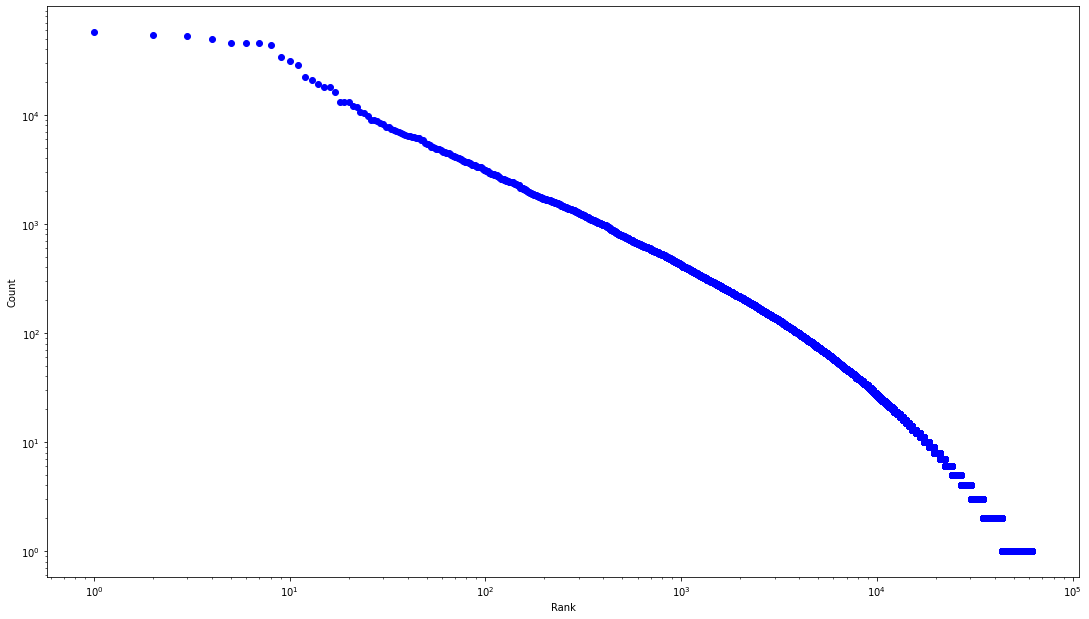

In [181]:
# 6. wykres logarytmiczny.
'''
    1. posortuj alfabetycznie
    2. posortuj po wystąpieniach
    3. Oś X ma mieć rank czyli iść po kolei od najczęstszego słowa do najrzadszego
    4. OŚ Y ma mieć ilość wytąpień.
'''

# full_count_sorted = sorted(full_count.items(), key=lambda item: (-item[1], item[0]))
# x = full_count_sorted[:,0]

x = range(1,full_count_sorted.shape[0]+1)
y = full_count_sorted[:,1].astype('int')

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

# ax.plot(x, y, color='b')
ax.scatter(x, y, color='b')

ax.set(xlabel='Rank', ylabel='Count')
# ax.legend(['additions','removals','changes'])
ax.set_yscale('log')
ax.set_xscale('log')

fig.savefig("test.png")
plt.show()

In [32]:
from morfeusz2 import *

morf = Morfeusz()
analysis_result = morf.analyse("ala, xd")
analysis_result, analysis_result[0][2][2]

([(0, 1, ('ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])),
  (0, 1, ('ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])),
  (0, 1, ('ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])),
  (1, 2, (',', ',', 'interp', [], [])),
  (2, 3, ('xd', 'xd', 'ign', [], []))],
 'subst:sg:nom:f')

In [33]:
counted_words = full_count_sorted[:,0]
print(counted_words[0])
not_in_morfeusz = []
for word in counted_words:
    morf_result = morf.analyse(word)
    if morf_result[0][2][2] == "ign":
        not_in_morfeusz.append(word)


not_in_morfeusz

do


['poz',
 'późn',
 'str',
 'GMO',
 'SWW',
 'operacyjno',
 'SKW',
 'zm',
 'ex',
 'IKE',
 'rolno',
 'techniczno',
 'remediacji',
 'rozdz',
 'URE',
 'UKE',
 'itp',
 'kN',
 'charytatywno',
 'sanitarno',
 'CN',
 'PKWiU',
 'UDT',
 'społeczno',
 'np',
 'BSWSG',
 'BSWP',
 'Społeczno',
 'Biobójczych',
 'organizacyjno',
 'PHS',
 'komandytowo',
 'wodociągowo',
 'HCFC',
 'architektoniczno',
 'FEP',
 'adopcyjno',
 'MgO',
 'dyplomatyczno',
 'UTK',
 'emerytalno',
 'FRD',
 'RON',
 'UOKiK',
 'CBŚP',
 'DOKE',
 'Rolno',
 'HACCP',
 'PCN',
 'vitro',
 'ITS',
 'kontrolno',
 'metylo',
 'inulinowego',
 'EFRROW',
 'fenylo',
 'diagnostyczno',
 'PCB',
 'PLK',
 'ureaformu',
 'biuretu',
 'Cu',
 'TDT',
 'szkolno',
 'ych',
 'ekonomiczno',
 'Poz',
 'disease',
 'psychologiczno',
 'tj',
 'pomiarowo',
 'Bankowania',
 'IIa',
 'IVa',
 'administracyjno',
 'hydrologiczno',
 'rozpuszc',
 'wymienion',
 'IIIa',
 'difenylo',
 'kulturalno',
 'metylomorfinan',
 'prefinansowanie',
 'Ww',
 'hydroksy',
 'ie',
 'Zn',
 'ureaform',
 'zal

In [34]:
# 8. 30 słów które nie są w morfeuszu
highest_not_in_morfeusz = OrderedDict()
for word, count in full_count_sorted:
    if word in not_in_morfeusz:
        highest_not_in_morfeusz[word] = count
    # print(word)


In [80]:
highest_not_in_morfeusz
highest_not_in_morfeusz_but_30 = list(highest_not_in_morfeusz.items())[:30]
list(highest_not_in_morfeusz.items())[:1000], np.array(list(highest_not_in_morfeusz.items())).shape

([('poz', '45203'),
  ('późn', '1065'),
  ('str', '516'),
  ('GMO', '298'),
  ('SWW', '216'),
  ('operacyjno', '209'),
  ('SKW', '196'),
  ('zm', '192'),
  ('ex', '167'),
  ('IKE', '162'),
  ('rolno', '160'),
  ('techniczno', '122'),
  ('remediacji', '120'),
  ('rozdz', '102'),
  ('URE', '101'),
  ('UKE', '97'),
  ('itp', '96'),
  ('kN', '95'),
  ('charytatywno', '87'),
  ('sanitarno', '84'),
  ('CN', '83'),
  ('PKWiU', '81'),
  ('UDT', '77'),
  ('społeczno', '73'),
  ('np', '71'),
  ('BSWSG', '70'),
  ('BSWP', '66'),
  ('Społeczno', '64'),
  ('Biobójczych', '55'),
  ('organizacyjno', '55'),
  ('PHS', '53'),
  ('komandytowo', '51'),
  ('wodociągowo', '47'),
  ('HCFC', '44'),
  ('architektoniczno', '44'),
  ('FEP', '42'),
  ('adopcyjno', '42'),
  ('MgO', '41'),
  ('dyplomatyczno', '41'),
  ('UTK', '40'),
  ('emerytalno', '39'),
  ('FRD', '36'),
  ('RON', '35'),
  ('UOKiK', '35'),
  ('CBŚP', '34'),
  ('DOKE', '34'),
  ('Rolno', '34'),
  ('HACCP', '32'),
  ('PCN', '32'),
  ('vitro', '32')

In [36]:
# 9. 30 słów które mają 5 wystąpień i nie są w morfeuszu
highest_not_in_morfeusz_with_5 = OrderedDict()
full_count_sorted_but_shuffled_xd = np.copy(full_count_sorted)
np.random.shuffle(full_count_sorted_but_shuffled_xd)

for word, count in full_count_sorted_but_shuffled_xd:
    if word in not_in_morfeusz and int(count) == 5:
        highest_not_in_morfeusz_with_5[word] = count

In [83]:
len(highest_not_in_morfeusz_with_5)
list(highest_not_in_morfeusz_with_5.items())[:30]
highest_not_in_morfeusz_with_5_but_30 = list(highest_not_in_morfeusz_with_5.items())


In [38]:
import Levenshtein
Levenshtein.distance("hell", "hello")

reg_html = regex.findall('(hello){e<=1}', "helo elo mello", flags=regex.IGNORECASE) 
# reg_html

In [96]:
# 10. przelec po słowach z 8 i 9 i znajdz słowa które moga pasowac najbardziej z morfeusza
# full_count_sorted
# jak dla mnie tu powinno być coś innego niż 30 najpopularniejszych
# 10.8
levenstein_suggestions_for_missing_words = []
for word, count in highest_not_in_morfeusz_but_30:
    # print(word)
    tmp = OrderedDict()
    for word_s, count_s in full_count_sorted:
        dist = Levenshtein.distance(word, word_s)
        tmp[word_s] = dist
    # print(tmp)
    levenstein_suggestions_for_missing_words.append(np.array(sorted(tmp.items(), key=lambda item: item[1]))[:10])


In [97]:
# 10.9
levenstein_suggestions_for_missing_words_with_5 = []
for word, count in highest_not_in_morfeusz_with_5_but_30:
    # print(word)
    tmp = OrderedDict()
    for word_s, count_s in full_count_sorted:
        dist = Levenshtein.distance(word, word_s)
        tmp[word_s] = dist
    # print(tmp)
    levenstein_suggestions_for_missing_words_with_5.append(np.array(sorted(tmp.items(), key=lambda item: item[1]))[:10])

In [99]:
# for i in levenstein_suggestions_for_missing_words:
for i in levenstein_suggestions_for_missing_words_with_5:
    first = True
    for m in i:
        if first:
            print(m[0]+": ", end=" ")
            first = False
        else:
            print(m[0]+", ", end=" ") # jesli chcemy wpisy z odległoscia to dać samo "m"
    print()
# levenstein_suggestions_for_missing_words_with_5

Avian:  avian,  zmian,  ścian,  Zmian,  van,  dnia,  organ,  zmiany,  Zmiany,  
ośc:  oś,  ości,  ość,  od,  moc,  on,  one,  ona,  ono,  
kJ:  kN,  kg,  km,  kW,  kV,  ka,  GJ,  MJ,  kG,  
ym:  tym,  im,  zm,  mm,  cm,  km,  wym,  yl,  nym,  
ami:  ani,  mi,  sami,  amo,  am,  amid,  admi,  wami,  art,  
tzn:  ten,  ton,  tzw,  tan,  czn,  za,  Dz,  tym,  ze,  
edukacyjno:  edukacyjne,  edukacyjną,  edukacyjna,  edukacyjny,  edukacyjnej,  edukacyjnym,  edukacyjnego,  edukacji,  edukacyjnych,  
regazyfikacyjnego:  ratyfikacyjnego,  weryfikacyjnego,  certyfikacyjnego,  kwalifikacyjnego,  identyfikacyjnego,  rehabilitacyjnego,  egzaminacyjnego,  regazyfikacji,  legalizacyjnego,  
najmnie:  najmniej,  najmie,  najmni,  nadanie,  zajmie,  najmiej,  najmn,  najniej,  nanie,  
tów:  ków,  tzw,  rów,  ów,  bów,  nów,  sów,  zów,  łów,  
wapnio:  wapnia,  wapno,  wapni,  ważnie,  wapniowy,  wapniowo,  wapna,  wania,  Wapno,  
GJ:  GT,  kJ,  MJ,  GR,  do,  na,  Nr,  od,  po,  
ppkt:  pkt,  akt,

In [5]:
#11. load sgjp
print("zaczynam")
try:
    start_flag = False
    cnt = 0
    with open('sgjp-20211107.tab', encoding='UTF-8') as f:
        for line in f:
            if start_flag:
                tmp = line.split('\t')
                # print(tmp)
                form = tmp[0]
                lemat = tmp[1]
                znacznik = tmp[2]
                # print(form)
                es.create(
                    index="test-index2",
                    id=cnt,
                    body={"text": form, "lemma": lemat, "sgn": znacznik}
                )
                cnt += 1
                if cnt % 100000 == 0:
                    print(cnt)
            else:
                if "#</COPYRIGHT>" in line:
                    print("zaczynam")
                    start_flag = True
except UnicodeDecodeError as e:
    print(e)
print("skonczylem")
# 7.4 mln. 373m 57s

zaczynam


C:\Users\oookk\AppData\Local\Temp/ipykernel_6276/2884611391.py:14: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.create(


100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
skonczylem


In [183]:
elastic_sgjp_levenstein = OrderedDict()
for word, count in highest_not_in_morfeusz_with_5_but_30:
    fuzzy_search = es.search(
        index="test-index2",
        body={
            "query": {
                "fuzzy": {
                    "text": {
                        "value": word,
                    }
                }
            },
        },
    )["hits"]["hits"]

    tmp = []
    for fuzzy_result in fuzzy_search:
        if fuzzy_result["_source"]["text"] not in tmp:
            tmp.append(fuzzy_result["_source"]["text"])
    elastic_sgjp_levenstein[word] = tmp



C:\Users\oookk\AppData\Local\Temp/ipykernel_6276/644942622.py:3: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  fuzzy_search = es.search(


In [130]:
# pprint.pprint(elastic_sgjp_levenstein)
# list(elastic_sgjp_levenstein.items())
for word, lev_list in list(elastic_sgjp_levenstein.items()):
    first = True
    print(word+": ", end=" ")
    for m in lev_list:
        print(m+", ", end=" ") # jesli chcemy wpisy z odległoscia to dać samo "m"
    print()

Avian:  
ośc:  Owc,  Ośce,  ośca,  ośce,  oścu,  ośm,  
kJ:  
ym:  
ami:  AM-ami,  AF-ami,  AIDS-ami,  AIF-ami,  AL-ami,  AMERBANK-ami,  ANS-ami,  AON-ami,  AP-ami,  
tzn:  tzn,  OZN,  TPN,  TVN,  Tin,  tan,  ten,  ton,  
edukacyjno:  edukacyjno,  edukacyjna,  edukacyjne,  edukacyjni,  edukacyjny,  edukacyjną,  
regazyfikacyjnego:  niegazyfikacyjnego,  denazyfikacyjnego,  gazyfikacyjnego,  
najmnie:  Najmanie,  najmniej,  najemnie,  Najmie,  najmie,  
tów:  Lów,  Otów,  Rów,  Sów,  Tód,  stów,  tóg,  mów,  
wapnio:  Wapnic,  Wapnico,  Wapnik,  Wapnie,  wapnic,  wapnico,  wapnij,  wapnią,  wapnić,  wapnię,  
GJ:  
ppkt:  pakt,  pkt,  
URT:  
geodezyjno:  geodezyjno,  geodezyjna,  geodezyjne,  geodezyjni,  geodezyjny,  geodezyjną,  
organicz:  ogranicz,  organicy,  Organach,  Organist,  odgranicz,  ogranicza,  ograniczy,  ograniczą,  
zawart:  Gawart,  Zapart,  Zawarta,  Zawarte,  Zawartą,  
heptanol:  heptanom,  heptanem,  heptanie,  heptanowi,  heptanów,  metanol,  heptanu,  heptany,  

In [175]:
r = zip(levenstein_suggestions_for_missing_words_with_5, list(elastic_sgjp_levenstein.items()))
# list(r)
tabl = []
for my, elastic in r:
    # print(my)
    # print(elastic)
    tmp = ", ".join([''.join(x) for x, y in my[1:]])
    tabl.append([elastic[0], ', '.join(elastic[1]), tmp])
# np.array(list(elastic_sgjp_levenstein.items()))
# for r in zip()
# np.array(list(elastic_sgjp_levenstein.items())).shape

In [176]:
# 12. Compare results
from tabulate import tabulate

print(tabulate(tabl, headers=["name", "elastic + sgjp", "levenstein morfeusz"], tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ name                │ elastic + sgjp                                                                        │ levenstein morfeusz                                                                                                                                                     │
╞═════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Avian               │                                                                                       │ avian, zmian, ścian, Zmian, van, dnia, org

In [ ]:
# 13. Conclusions
1. the distribution of words in the corpus:
Najwięcej słów w ustawie (z najwyższym rank) jet słów krótkich i to nie tylko spójników, ale też skrótów "art", "ust", "poz" itd. 
Większość najczęściej stosowanych słów to słowa będące konstruktorami korpusu (tj. słowami które budują środowisko do wprowadzania pojęć).
[['do', '57269'],['ust', '53631'],['art', '52961'],['na', '49421'],['się', '45882'],['lub', '45800'],['poz', '45203'],['Nr', '43418'],['oraz', '33552'],['Art', '30838'],['mowa', '28780'],['nie', '22345'],['przez', '20731'],['pkt', '19124'],['dnia', '17937'],['których', '17928'],['od', '16032'],['jest', '13193'],['ustawy', '13067'],['po', '12991'],['może', '12076'],['którym', '11787'],['brzmienie', '10576'],['za', '10328'],['otrzymuje', '9835'],
Pierwsze N słów z najwyższym rank jest niewiele, bardzo szybko kolejne ranki tracą na ilości słów.
Można powiedzieć że dostarczony korpus zawiera ustawy dotyczące różnych tematów.
Generalnie też można zauważyć, że przeważnie dłuższe słowa są dalej w rank.
Im dalej z rank, tym więcej jest słów których jest mało.
2. the number of true misspellings vs. the number of unknown words:
W sumie wychodzi na to, że (bazując na danych ground-truth) większość braków i problemów ze słowami to nie ich błędne formy, a słowa których nie ma po prostu w niektórych słownikach. Morfeusz nie zawiera wielu słów które sa w SGJP.
3. the performance of your method compared to ElasticSearch:
Tu w ogóle nie ma podejścia. 
Analizując czasy wykonania: Elastic ok. 0.2s, moja implementacja: ok. 19.5s to prawie 100-krotna różnica w czasie. Dla operacji długich (a przekonałem się o tym ładując SGJP) różnica 100 krotna to albo 5 minut albo 30 godzin. Nie muszę mówić co lepsze.
W końcu złożoność mojego algorytmu to O(N*M + s) a elastic jest raczej O(log(M)) lub O(M * log(N)).
4. the results provided by your method compared to ElasticSearch:
Zaglądając to wyników w tabeli widać, że Elastic + SGJP w wielu przypadkach po prostu nie znalazł odpowiedniego słowa, a moja metoda tak.
Generalnie moja metoda znajduje teoretycznie więcej pasujących elementów ale to dlatego, że nie ograniczam jej długością levensteina. 
Ilościowo moje podejście daje lepsze wyniki. Jakościowo to zależy.
Są nazwy własne albo skrótowce, które Elastic + SGJP ogarniają dobrze, a mój algorytm daje wyniki bardzo losowe w porównaniu do nich. Ale są też skróty których Elastic + SGJP nie dali rady rozszyfrować.
Z drugiej strony Elastic + SGJP potrafi sugerować nazwy własne do po prostu zwykłych słów lub do błędów.
Generalnie Elastic + SGJP daje lepsze wyniki dla faktycznie istniejących słów, nazw, własnych i skrótowców, ale jeśli chodzi o literówki i błędy to moje podejście wygląda lepiej.
5. the validity of the obtained corrections:
Pomijając kwestie z pkt. 4, 
jeśli chodzi o błędy jak np. ośc, ami, najmnie, rialnego itd, to większość pierwszych sugesti mojej implementacji daje lepsze wyniki niż te z Elastica + SGJP.
Jednak moich wyników jest dużo więcej i często są błędne, a trzeba je i tak sprawdzić. Biorąc pod uwagę ilość wyników do faktycznego błędu, to Elastic jest chyba lepszą opcją.